In [1]:

import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Huseyin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Huseyin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:

data = pd.read_csv('etiketlenen_veri.csv')
stop_words = set(stopwords.words('turkish'))

def clean_comment(comment):
    comment = re.sub(r'\W', ' ', comment)  
    comment = re.sub(r'\d+', '', comment)  
    comment = comment.lower()  
    word_tokens = word_tokenize(comment) 
    filtered_words = [word for word in word_tokens if word not in stop_words] 
    return filtered_words

data['cleaned_comment'] = data['comment'].apply(clean_comment)


In [4]:
model_w2v = Word2Vec(sentences=data['cleaned_comment'], vector_size=100, window=5, min_count=1, workers=4)

def vectorize_comments(comments, model):
    vecs = []
    for comment in comments:
        word_vecs = [model.wv[word] for word in comment if word in model.wv]
        if word_vecs:  
            vec = np.mean(word_vecs, axis=0)
        else:  
            vec = np.zeros(model.vector_size)
        vecs.append(vec)
    return np.array(vecs)

X = vectorize_comments(data['cleaned_comment'], model_w2v)



In [5]:
le = LabelEncoder()
y = le.fit_transform(data['sentiment'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)), 
    Dropout(0.3), 
    Dense(64, activation='relu'), 
    Dropout(0.3),
    Dense(len(set(y)), activation='softmax')  
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               12928     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                                 
Total params: 21379 (83.51 KB)
Trainable params: 21379 (83.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20


32/32

8/8 [==============================] - 0s 1ms/step
Test Doğruluğu: 46.27%


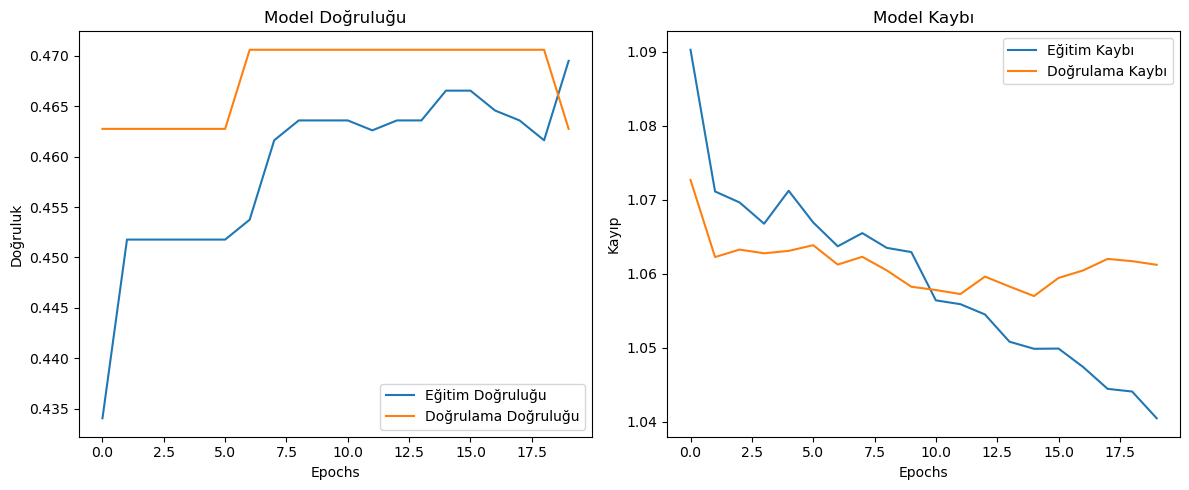

In [7]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
accuracy = (y_pred == y_test).mean()
print(f"Test Doğruluğu: {accuracy * 100:.2f}%")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.xlabel('Epochs')
plt.ylabel('Doğruluk')
plt.legend()
plt.title('Model Doğruluğu')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.xlabel('Epochs')
plt.ylabel('Kayıp')
plt.legend()
plt.title('Model Kaybı')

plt.tight_layout()
plt.show()


In [8]:
model.save('model.h5')
print("Model kaydedildi.")


Model başarıyla kaydedildi.


C:\Users\Huseyin\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
